In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
denorm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
import net
import dataset

val_dataset = dataset.VocDataSet(split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=1)

model = net.UNet(n_channels=3, n_classes=21, bilinear=False)
checkpoint = torch.load('model_unet.pth', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

Found 1449 images in the folder data/VOCdevkit/VOC2012


<All keys matched successfully>

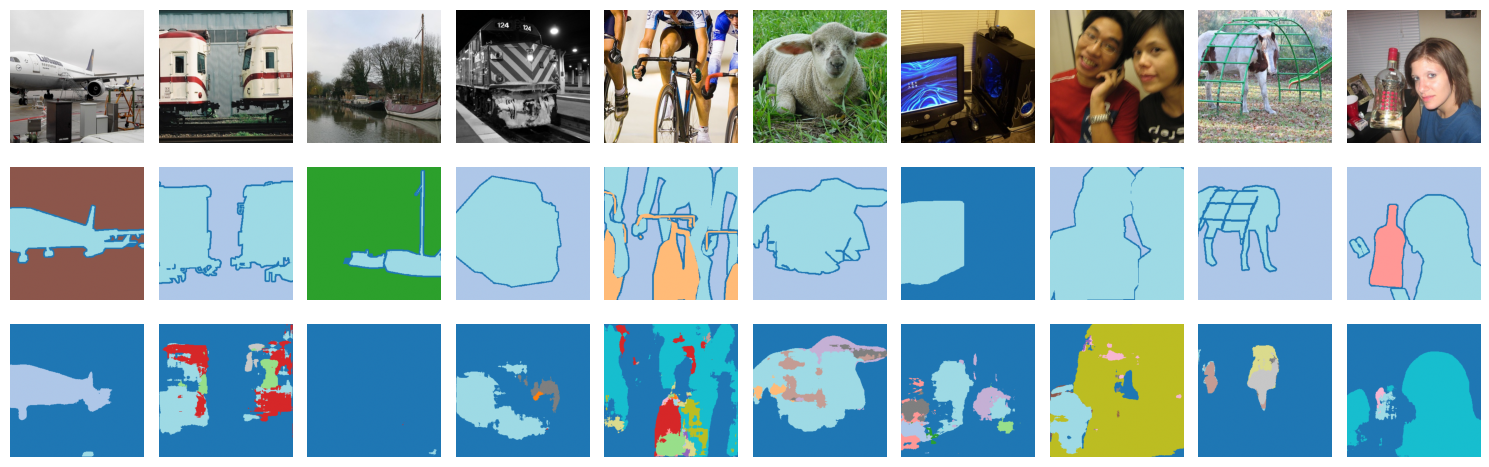

In [5]:
def get_images(n, model):
    total = 0
    total_images = []
    total_targets = []
    total_predictions = []
    model.eval()
    for images, targets, _ in val_loader:
        total_images.append(images)
        total_targets.append(targets)
        with torch.no_grad():
            outputs = model(images)
            predictions = F.softmax(outputs, dim=1).argmax(dim=1)
            total_predictions.append(predictions)
        total += len(images)
        if total >= n:
            break
    return torch.cat(total_images)[:n], torch.cat(total_targets)[:n], torch.cat(total_predictions)[:n]

def plot_cmp(n):
    images, targets, predictions = get_images(n, model)
    fig, axes = plt.subplots(3, n, figsize=(15, 5))
    for i in range(n):
        # Original image (denormalize for visualization)
        img = denorm(images[i]).permute(1, 2, 0).numpy().clip(0, 1)
        axes[0, i].imshow(img)
        # Ground truth
        axes[1, i].imshow(targets[i], cmap='tab20')
        # Prediction
        axes[2, i].imshow(predictions[i], cmap='tab20')
    for ax in axes.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plot_cmp(10)

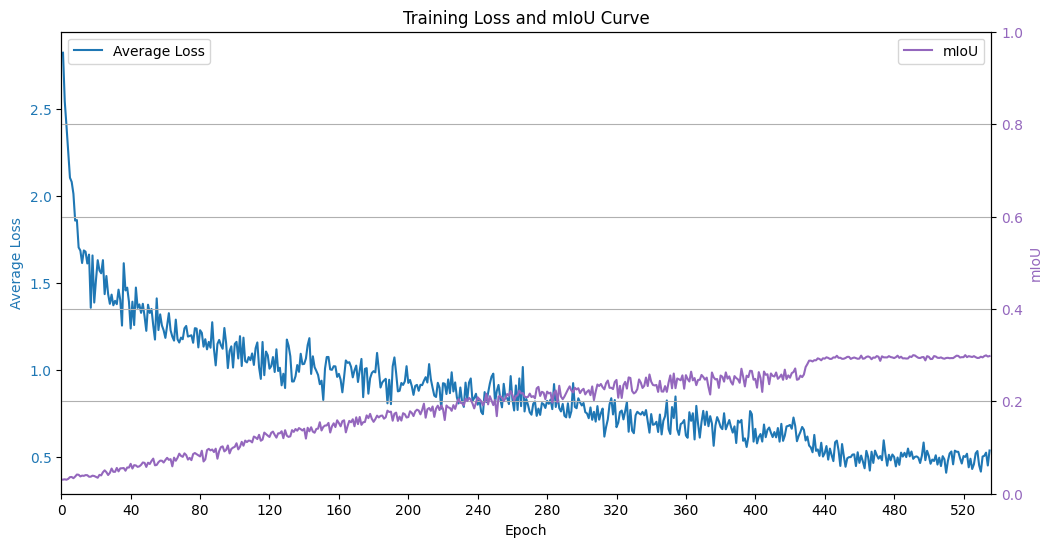

In [15]:
import re
with open('unet.log', 'r') as file:
    lines = file.readlines()

# 初始化变量
epoch_losses = []
epoch_miou = []
current_epoch_losses = []
current_epoch = 1

# 遍历文件内容
for line in lines:
    # 检测是否为Batch行
    if line.startswith("Batch"):
        # 提取损失值
        match = re.search(r'Loss: (\d+\.\d+)', line)
        if match:
            loss = float(match.group(1))
            current_epoch_losses.append(loss)
    # 检测是否为Epoch行
    elif line.startswith("Epoch:"):
        # 计算当前epoch的平均损失
        if current_epoch_losses:
            epoch_loss = sum(current_epoch_losses) / len(current_epoch_losses)
            epoch_losses.append(epoch_loss)
            current_epoch_losses = []
        # 提取mIoU值
        match = re.search(r'mIoU: (\d+\.\d+)', line)
        if match:
            miou = float(match.group(1))
            epoch_miou.append(miou)
        # 更新当前epoch
        current_epoch += 1
    else:
        continue

# 计算最后一个epoch的平均损失（如果还有未处理的损失值）
if current_epoch_losses:
    epoch_loss = sum(current_epoch_losses) / len(current_epoch_losses)
    epoch_losses.append(epoch_loss)

epochs = list(range(1, len(epoch_losses) + 1))

# 设置绘图的大小
plt.figure(figsize=(12, 6))

# 创建主轴（用于绘制平均损失）
ax1 = plt.gca()  # 获取当前轴
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss', color='tab:blue')
ax1.plot(epochs, epoch_losses, color='tab:blue', label='Average Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')  # 设置y轴刻度颜色
ax1.set_xlim(0, len(epoch_losses) + 1)
ax1.set_xticks(range(0, len(epoch_losses) + 1, 40))

# 创建次轴（用于绘制mIoU）
ax2 = ax1.twinx()  # 创建共享x轴的次轴
ax2.set_ylim(0, 1.0)
ax2.set_ylabel('mIoU', color='tab:purple')  # 设置y轴标签和颜色
ax2.plot(epochs, epoch_miou, color='tab:purple', label='mIoU')
ax2.tick_params(axis='y', labelcolor='tab:purple')  # 设置y轴刻度颜色

# 添加标题和图例
plt.title('Training Loss and mIoU Curve')
ax1.legend(loc='upper left')  # 主轴图例
ax2.legend(loc='upper right')  # 次轴图例
plt.grid(True)

# 显示图形
plt.show()